## 什么是优化器

[https://www.youtube.com/watch?v=Ym1m4Bh14ps](https://www.youtube.com/watch?v=Ym1m4Bh14ps)

* 用来寻找函数最小值
* 从数据中查找并建立参数化模型（从实验数据中找到一个多项式来拟合实验数据）
* 使用优化器来改善股票投资组合中的分配方式

In [1]:
import pandas as pd
import quantaxis_ext
from QUANTAXIS import QA_fetch_stock_day_adv
from QUANTAXIS import QA_fetch_index_day_adv
import ploter
import talib
import numpy as np
import settings
import units
import header
import calculator as calc
import matplotlib.pyplot as plt

#设定绘图的默认大小
import matplotlib
matplotlib.rcParams["figure.figsize"]=[16,5]

#加载 seaborn，并且设置默认使用 seaborn
import seaborn as sns
sns.set()

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Noto Sans CJK SC','SimHei']
matplotlib.rcParams['axes.unicode_minus']=False #用来正常显示负号

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

QUANTAXIS>> Expand macros in c:\program files\python37\lib\site-packages\macropy\core\hquotes.py
QUANTAXIS>> Finding macros in 'macropy.core.hquotes'
QUANTAXIS>> Importing macros from 'macropy.core.quotes' into 'macropy.core.hquotes'
QUANTAXIS>> Expand macros in c:\program files\python37\lib\site-packages\macropy\core\quotes.py
QUANTAXIS>> Finding macros in 'macropy.core.quotes'
QUANTAXIS>> Expand macros in c:\program files\python37\lib\site-packages\macropy\core\failure.py
QUANTAXIS>> Finding macros in 'macropy.core.failure'
QUANTAXIS>> Importing macros from 'macropy.core.hquotes' into 'macropy.core.failure'
QUANTAXIS>> Expand macros in c:\program files\python37\lib\site-packages\cffi\api.py
QUANTAXIS>> Finding macros in 'cffi.api'
QUANTAXIS>> Expand macros in c:\program files\python37\lib\site-packages\scipy\__config__.py
QUANTAXIS>> Finding macros in 'scipy.__config__'


In [2]:
START_VALS = 1000000 # 初始投资总额
START = '2018-01-01' # 初始投资日期
END = '2018-12-31' # 结束投资日期
# 投资组合：贵州茅台、中国平安、招商银行、格力电器
SYMBOLS = ['600519','601318','600036','000651'] 
# 比率分配
ALLOCS = [0.4,0.4,0.1,0.1]
ZS_CODE='000300'#指数代码。沪深300

In [3]:
def get_portfoilo(symbols, zs_code, start_date, end_date, start_values):
    """获取投资组合与指数的收益比较

    :param symbols: 投资组合
    :param zs_code: 指数代码
    :param start: 开始日期
    :param end: 结束日期
    :param allocs: 投资组合比率
    :param start_values: 初始总投资额
    :return: 包含指数的收盘价归一化后的数据
    """
    df=quantaxis_ext.fetch_index_stock_daily_adv(symbols,zs_code, start_date,end_date)
    normed = calc.calc_normalize_data(df)
    return normed

def plot_portfoilo(symbols, zs_code, start_date, end_date, allocs, start_values):
    normed = get_portfoilo(symbols, zs_code, start_date, end_date, start_values)
    alloced = normed.copy().drop('zs_'+ZS_CODE, axis=1) * allocs
    pos_vals = alloced * START_VALS
    port_val = pos_vals.sum(axis=1)
    normed_portfoilo=calc.calc_normalize_data(pd.DataFrame(port_val.copy(), columns=['投资组合']).join(normed['zs_'+ZS_CODE]))
    # normed_portfoilo.head(),normed_portfoilo.tail()
    normed_portfoilo.plot()
    plt.title('投资组合每日总价值与指数({4})间的对比\n投资组合：{0}\n分配比率：{1}\n周期：{2}~{3}'.format(symbols,allocs,start_date, end_date,zs_code))
    
    normed_portfoilo.tail(1)

### 投资组合每日总价值与指数间的对比

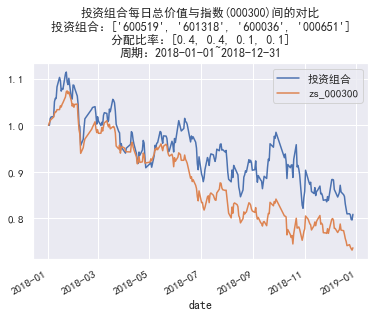

In [4]:
# 投资组合一年的表现与沪深300指数的比较
plot_portfoilo(SYMBOLS, ZS_CODE, START, END, ALLOCS, START_VALS)

### 修改投资组合分配比率

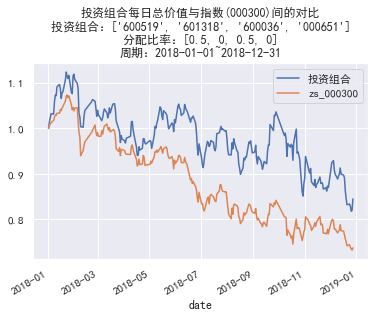

In [5]:
# 投资组合一年的表现与沪深300指数的比较
plot_portfoilo(SYMBOLS, ZS_CODE, START, END, [0.5,0,0.5,0], START_VALS)

## 关于组合优化的说明

* [https://github.com/czielinski/portfolioopt](https://github.com/czielinski/portfolioopt)

* [使用ScienceOps优化货币组合](ipynbs/Currency%20Portfolio%20Optimization_%E4%BD%BF%E7%94%A8ScienceOps%E4%BC%98%E5%8C%96%E8%B4%A7%E5%B8%81%E7%BB%84%E5%90%88.ipynb)

* [https://en.wikipedia.org/wiki/Portfolio_optimization](https://en.wikipedia.org/wiki/Portfolio_optimization)

* [https://www.portfoliovisualizer.com/examples](https://www.portfoliovisualizer.com/examples)

* [https://stanford.edu/class/ee103/lectures/portfolio_slides.pdf](https://stanford.edu/class/ee103/lectures/portfolio_slides.pdf)

* [https://www.factorresearch.com/research-stock-portfolio-optimisation](https://www.factorresearch.com/research-stock-portfolio-optimisation)

# 优化投资组合

首先计算投资组合单个的日回报率。这里的日回报率0.047975，表示上涨4.7975%。

In [12]:
#投资组合日回报率
daily_return=quantaxis_ext.fetch_index_stock_daily_adv(SYMBOLS, ZS_CODE, START, END).pct_change()
daily_return.tail()

,zs_000300,600519,601318,600036,000651
date,,,,,
2018-12-24,0.002905,0.001040,-0.001543,0.002363,0.003050
2018-12-25,-0.006886,-0.003891,-0.000687,-0.006287,-0.008292
2018-12-26,-0.005054,-0.010092,-0.015633,-0.017398,0.000000
2018-12-27,-0.003837,0.005214,-0.006981,0.000000,-0.005574
2018-12-28,0.006735,0.047975,-0.014060,0.014085,0.000280


In [26]:
daily_return.describe()

,zs_000300,600519,601318,600036,000651
count,242.000000,242.000000,242.000000,242.000000,242.000000
mean,-0.001172,-0.000476,-0.000867,-0.000483,-0.000706
std,0.013489,0.022485,0.019890,0.019234,0.023067
min,-0.047992,-0.100000,-0.066097,-0.064414,-0.089674
25%,-0.008620,-0.013649,-0.012464,-0.012367,-0.013974
50%,-0.001189,-0.002131,-0.000782,-0.000700,-0.002888
75%,0.006632,0.013026,0.011751,0.011688,0.011034
max,0.043165,0.065542,0.050761,0.068696,0.100097


### 组合中平均日收益最高的股票

In [29]:
daily_return.mean().idxmax()

'600519'

以组合中平均收益最大的股票 600519 来说，它的日平均收益为 -0.00048，标准差为 0.02248。

In [40]:
import math
from scipy import stats
n = len(daily_return)
mean_600519 = daily_return['600519'].mean()
std_600519 = daily_return['600519'].std()
'{:.5f},{:.5f}'.format(mean_600519,std_600519)

'-0.00048,0.02248'

以下数据给出了95％的置信区间，即 600519 的预期日回报率在 -0.04%和0.04% 之间。

In [43]:
prob=stats.norm.pdf(0,mean_600519,std_600519) #在0处概率密度值
pre=stats.norm.cdf(0,mean_600519,std_600519)  #预测小于0的概率
interval=stats.norm.interval(0.95,mean_600519,std_600519)  #96%置信水平的区间
print('0处概率密度值:{:.3f}'.format(prob))
print('小于0的概率是:{:.3f}'.format(pre))
print('95%的置信区间是:({})'.format(interval))

0处概率密度值:17.739
小于0的概率是:0.508
95%的置信区间是:((-0.044544836241998, 0.043592967023867994))


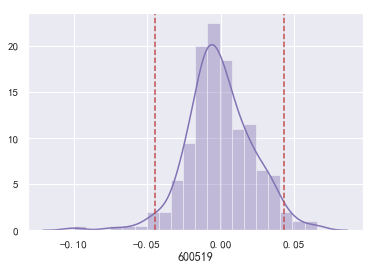

In [54]:
# daily_return['600519'].plot(kind='hist')
sns.distplot(daily_return['600519'].dropna(), color="m")
plt.axvline(interval[0], color='r', linestyle='--', label='置信区间')
plt.axvline(interval[1], color='r', linestyle='--', label='置信区间')

这意味着我们的最高收益股票(600519)的预期回报可能是负面的，也可能是正面的。
所以就算是我们把所有的资金全部投入 600519 中，也可能会面临每日损失 0.04% 的资金。